# Designing a plagiarism detector

The plagiarism is the common type of misconduct in the academic and other settings. It is especially essential to catch the plagiarism in the students' papers to not only celebrate the justice and ownership of unique thoughts but also to provide the equality to the students who work hard and those who don't but use others work in the inappropriate ways.

It is also important though to define what the plagiarism is. University of Oxford states that:

Plagiarism is presenting someone else’s work or ideas as your own, with or without their consent, by incorporating it into your work without full acknowledgement (Reference 1). 

For this paper, we need to specify the term even more. Plagiarism in this paper is the similarity between two texts expressed in different metrics: from the number of similar k-grams (substrings of length k) to the percentage of similar hashes of k-grams in the text.

We will use various techniques from Rolling Hashing (or Rabin-Karp Algorithm) to the Chaining Collision Resolution in order to obtain reliable and fast plagiarism detector.

## Imports

In [1]:
import numpy as np
import math
import re
import random
import time
import matplotlib.pyplot as plt
import string

## First implementation: Rolling Hashing

Firstly, we use Rolling Hashing to match the two input strings. This method is one of the great methods to make the hashing much faster, while reliable. 

This method is based on the assumption that we use **mod** operator in the hash function and, therefore, can easily get the hash value of the string without first symbol or with new last symbol with making one simple operation to the original hash value.

Before doing hashing, I preprocessed the input text to exclude any unneeded characters such as punctuation and make all the letter lowercase. The result of this preprocessing is the one big string without any punctuation (even spaces) in lower case.

The justification of some of the design choices:

1. There is no intended table size as we can use python dictionary which can handle the size changes.

2. Collisions are resolved by chaining. Here, as we used large value of q, we have not a lot of collisions. Therefore, chaining will give us little lengthed lists (in most cases from 1 element), so the speed will be not affected by chaining.

3. The q is equal to 10007, which is a prime number. It is quite big, so the number of collisions will be as small as possible. If the texts that someone intend to use are big, it can be even switched to the larger prime number.

4. We use Python Dictionary as a hash table as it is the great data structure that can deal with size itself.

More information about the other steps are in the code comments.

In [2]:
REPLACE = re.compile('[ /(){}\[\]\|@,;]|[^0-9a-z #+_]')

def preprocessing(text):
    
    """
    Preprocess text to obtain the string without the punctuation
    
    Input:
    - text : str
             original string
             
    Output:
    - text : str
             preprocessed string
    """
    
    text = text.lower() # lower the letters
    text = REPLACE.sub('', text) # replace the unnecessary characters in the text
    return text
    

def hash_val_for_string(string, k, hash_table, q): 
    
    """
    Put all k-gram substrings to the hash table as values, while hashes are keys.
    
    Input:
    - string : str
             preprocessed string
    - k : int
             size of substring      
    - hash_table : dict
             empty hash table
    - q : int
             prime number to use in hash function
             
    Output:
    - hash_table : dict
             hash table with all the k-grams from the string with their indices in the string
             
    - h : int
             the important variable, we return it to save the computation time in the next function
    """
    
    d = 256              # size of the vocabulary
    h = 1                # needed variable for calculations
    for i in range(k-1): # calculation of h
        h = (h * d)% q   
    j = 0                # index in the string
    t = 0                # hash value
    for i in range(k):
        t = (d * t + ord(string[i]))% q # hash value of the first window
    
    hash_table[t] = [(string[:k], j)] # add the first hash value to the table with the tuple for the k-gram and its index
    
    N = len(string)      # length of the string 
    
    for i in range(N - k + 1):  # loop to go through all substrings (N-k+1) because the last window must be
                                # of the length k
        if i < N - k:           # if i < N - k, renew hash value
            t = (d * (t - ord(string[i]) * h) + ord(string[i + k])) % q # recalculate the hash value
  
            if t < 0:           # if hash value is negative -> make it positive
                t = t + q 
            j += 1              # increase index
            
            if t in hash_table: # if hash exists in hash table, append the list
                hash_table[t].append((string[i+1: i+1+k], j))
                
            else:               # if hash is not in hash table, create a new sublist in the hash table
                hash_table[t] = [(string[i+1: i+1+k], j)]
                
    return (hash_table, h)

def strings_similarity(string, k, hash_table, q, h): 
    
    """
    Search for similarities between the hash table for the string_x, and the string_y using rolling hashing.
    
    Input:
    - string : str
             preprocessed string
    - k : int
             size of substring      
    - hash_table : dict
             empty hash table
    - q : int
             prime number to use in hash function
    - h : int
             variable needed for calculation from the previous function      
             
    Output:
    - hash_table : list of tuples
             hash table with all the k-grams from the string with their indices in the string
             
    """
    
    d = 256 # size of the vocabulary
    t = 0   # hash value
    ind = 0 # index in string_y   
    
    for i in range(k): 
        t = (d * t + ord(string[i]))% q # hash value of the first window
        
    N = len(string) # length of the string 
    list_of_matches = [] # create a list of matches
    for i in range(N - k + 1): # loop to go through all substrings (N-k+1) because the last window must be
                               # of the length k
            
        if t in hash_table:         # if hash exists in hash table,
            for l in hash_table[t]: # check all the items in the sublist for this hash
                if string[i : i + k] == l[0]: # check if the substring in string_y is the same as the item in the sublist
                    list_of_matches.append((l[1], i)) #if so, append the list of matches with the indices
                    
        if i < N-k:                 # if i < N - k, renew hash value
            t = (d*(t-ord(string[i])*h) + ord(string[i + k]))% q # recalculate the hash value
  
            if t < 0:               # if hash value is negative -> make it positive
                t = t + q 
        
    return list_of_matches

def rh_get_match(x, y, k):
    
    """
    Finds all common length-k substrings of x and y
    using rolling hashing on both strings.
    Input:
    - x, y: strings
    - k: int, length of substring
    Output:
    - A list of tuples (i, j) where x[i:i+k] = y[j:j+k]
    """
    hash_table = {} # create a hash table
    
    hash_table, h = hash_val_for_string(x, k, hash_table, 10007) # create a hash table for string_x
    
    list_of_match = strings_similarity(y, k, hash_table, 10007, h) # search for the similarities
    
    return list_of_match

Now, we will use the created function to get matches in the specific strings.

First example is used to check how preprocessing function works. As we can see, it works as expected. Also, we use the *rh_get_match* to find the matches between two strings and it works well in this example.

In [18]:
print(preprocessing("Hello, @%guys m:an"))
print(preprocessing("     sman"))
rh_get_match(preprocessing("Hello, @%guys m:an"), preprocessing("     sman"), 3)

helloguysman
sman


[(8, 0), (9, 1)]

Here, we use three more test cases from the popular articles about plagiarism. As we can see, the code works perfectly in all of these cases.

In [4]:
# These examples of plagiarism is brought from Examples of Plagiarism. (n.d.). Retrieved December 18, 2020, from https://www.bowdoin.edu/dean-of-students/judicial-board/academic-honesty-and-plagiarism/examples.html

string_x = preprocessing("Long ago, when there was no written history, these islands were the home of millions of happy birds; the resort of a hundred times more millions of fishes, sea lions, and other creatures. Here lived innumerable creatures predestined from the creation of the world to lay up a store of wealth for the British farmer, and a store of quite another sort for an immaculate Republican government.")
string_y = preprocessing("In ages which have no record these islands were the home of millions of happy birds, the resort of a hundred times more millions of fishes, of sea lions, and other creatures whose names are not so common; the marine residence, in fact, of innumerable creatures predestined from the creation of the world to lay up a store of wealth for the British farmer, and a store of quite another sort for an immaculate Republican government.")
# print the indices of matches
print(rh_get_match(string_x, string_y, 150))
print("\n")
# check if substrings are the same
for i in rh_get_match(string_x, string_y, 150):
    print(string_x[i[0]:i[0]+150] == string_y[i[1]:i[1]+150])

[(158, 189), (159, 190), (160, 191), (161, 192), (162, 193), (163, 194), (164, 195), (165, 196), (166, 197)]


True
True
True
True
True
True
True
True
True


In [5]:
# The original text (string_x) us brought from Macroeconomics. (2020, December 06). Retrieved December 18, 2020, from https://en.wikipedia.org/wiki/Macroeconomics
# This example of plagiarism (string_y) is brought from Paraphrasing (or Summarizing) Without Citation - NIU - Academic Integrity Tutorial for Students. (n.d.). Retrieved December 18, 2020, from https://www.niu.edu/academic-integrity/students/plagiarism/paraphrasing-without-citation.shtml

string_x = preprocessing("The original theoretical impetus was the charge that Keynesian economics lacks microeconomic foundations -- i.e. its assertions are not founded in basic economic theory. This school emerged during the 1970s. This school asserts that it does not make sense to claim that the economy at any time might be 'out-of-equilibrium'. Fluctuations in aggregate variables follow from the individuals in the society continuously re-optimizing as new information on the state of the world is revealed.")
string_y = preprocessing("Scholars in the school of new classical economics, which emerged in the 1970s, focus on the belief that the school of Keynesian economics is misguided. New classical scholars assert that the economy is never unbalanced, as Keynesian scholars believe, but instead that changes in an economy result from people's changing their spending habits as they interpret the news about the world.")
# print the indices of matches
print(rh_get_match(string_x, string_y, 15))
print("\n")
# check if substrings are the same by printing them and looking at them
for i in rh_get_match(string_x, string_y, 15):
    print(string_x[i[0]:i[0]+15])
    print(string_y[i[1]:i[1]+15])
    print("\n")

[(45, 95), (46, 96), (47, 97), (48, 98)]


keynesianeconom
keynesianeconom


eynesianeconomi
eynesianeconomi


ynesianeconomic
ynesianeconomic


nesianeconomics
nesianeconomics




In [22]:
# This example of valid paraphrasing (string_y) was brought from Academic Integrity at MIT. (n.d.). Retrieved December 18, 2020, from https://integrity.mit.edu/handbook/academic-writing/avoiding-plagiarism-paraphrasing
# The original text (string_x) is from Thurow, L. (1993). Fortune Favors the Bold (p. 6). New York: Harper Collins.

string_x = preprocessing("Because of their unique perspective, Americans fear globalization less than anyone else, and as a consequence they think about it less than anyone else. When Americans do think about globalization, they think of the global economy as an enlarged version of the American economy.")
string_y = preprocessing("Lester Thurow (1993) maintains that because Americans see globalization simply as a bigger form of their own economy, they are less concerned about it than is the rest of the world.")
# print the indices of matches
print(rh_get_match(string_x, string_y, 5))

[(0, 29), (1, 30), (2, 31), (30, 35), (214, 35), (31, 36), (130, 36), (215, 36), (32, 37), (131, 37), (216, 37), (33, 38), (132, 38), (217, 38), (34, 39), (133, 39), (218, 39), (35, 40), (134, 40), (177, 47), (44, 48), (151, 48), (178, 48), (45, 49), (152, 49), (179, 49), (46, 50), (153, 50), (47, 51), (154, 51), (48, 52), (155, 52), (49, 53), (156, 53), (50, 54), (157, 54), (51, 55), (158, 55), (52, 56), (159, 56), (7, 80), (173, 80), (210, 80), (8, 81), (9, 82), (222, 89), (184, 90), (223, 90), (185, 91), (224, 91), (186, 92), (225, 92), (101, 117), (146, 117), (102, 118), (103, 119), (7, 137), (173, 137), (210, 137)]


## Second Implementation: Hashing with Chaining

In the second part of the paper, we implement the 'usual' hashing in which we are not using any optimization to go through strings and calculate hashes. We use the same preprocessing as in the first implementation.

The justification of some of the design choices:

1. There is no intended table size as we can use python dictionary which can handle the size changes.
2. Collisions are resolved by chaining. Here, we are not using division, so the possibility of having the same hash is minimal. Therefore, chaining will give us little lengthed lists (in most cases from 1 element), so the speed will be not affected by chaining.
4. We use Python Dictionary as a hash table as it is the great data structure that can deal with size itself.
5. The hash function is brought from the CS110 lesson on hash tables. It is a great hash function for strings as it uses all the letters in a string to calculate hash, it is deterministic, and it is easy to calculate.

More information about the other steps are in the code comments.

In [7]:
def hash_func(string):
    """
    Calculate hash value for the string.
    
    Input:
    - string : str
             preprocessed string
             
    Output:
    - ans : int
             hash value for the string
    """
    ans = 0                         # initial hash value
    for chr in string:              # loop through every character
        ans = ans * 128 + ord(chr)
    return ans


def add_to_hash_table(hash_table, item, hash_function):
    
    """
    Add the item to hash table.
    
    Input:
    - hash_table : dict
             empty hash table
    - hash_function : function
             hash function
    - item : tuple
             tuple of substring and its starting index in string            
             
    Output:
    - hash_table : dict
             hash table with the new item
    """


    s = hash_function(item[0]) # calculate hash function for the substring
    
    if s in hash_table:             # if hash exists in hash table,
        hash_table[s].append(item)  # add this substring to the sublist for this hash

    else:                           # if hash does not exists in hash table,
        hash_table[s] = [item]      # create a new sublist with the substring in it

    return hash_table

def contains(hash_table, item, hash_function):
    """
    Check if the item is in the hash table.
    
    Input:
    - hash_table : dict
             empty hash table
    - hash_function : function
             hash function
    - item : tuple
             tuple of substring and its starting index in string            
             
    Output:
    - l : list of tuples
             list of pairs of indices in string_x and string_y             
    """
    s = hash_function(item[0])    # calculate hash function for the substring  
    
    l = []                        # create an empty list
    
    if s in hash_table:           # if hash exists in hash table,
        
        for i, j in hash_table[s]:# go through every item, index pair in the sublist for this hash

            if item[0] == i:      # if substring is the same append list l with two indices
                l.append((j, item[1]))
    
    return l


def regular_get_match(x, y, k):
    """
    Finds all common length-k substrings of x and y
    NOT using rolling hashing on both strings.
    Input:
    - x, y: strings
    - k: int, length of substring
    Output:
    - A list of tuples (i, j)
    where x[i:i+k] = y[j:j+k]
    """
    hash_table = {} # create empty hash table
    
    # create two lists with all k-grams from two strings
    res = [(x[i: j], i) for i in range(len(x)) for j in range(i + 1, len(x) + 1) if len(x[i:j]) == k] 
    res1 = [(y[i: j], i) for i in range(len(y)) for j in range(i + 1, len(y) + 1) if len(y[i:j]) == k]
    
    for t in res:  # create a loop through every k-gram in 1st string
        add_to_hash_table(hash_table, t, hash_func) #add it to hash table
        
    list_of_matches = [] # create empty list
    
    for t in res1: # create a loop through every k-gram in 2nd string
        if contains(hash_table, t, hash_func): # check if k-gram is in the hash table for 1st string
            list_of_matches.extend(contains(hash_table, t, hash_func)) # add indices of match to the list
    
    return list_of_matches
                        

Here, we use three test cases from the popular articles about plagiarism. As we can see, the code works perfectly in all of these cases.

In [8]:
# These examples of plagiarism is brought from Examples of Plagiarism. (n.d.). Retrieved December 18, 2020, from https://www.bowdoin.edu/dean-of-students/judicial-board/academic-honesty-and-plagiarism/examples.html

string_x = preprocessing("Long ago, when there was no written history, these islands were the home of millions of happy birds; the resort of a hundred times more millions of fishes, sea lions, and other creatures. Here lived innumerable creatures predestined from the creation of the world to lay up a store of wealth for the British farmer, and a store of quite another sort for an immaculate Republican government.")
string_y = preprocessing("In ages which have no record these islands were the home of millions of happy birds, the resort of a hundred times more millions of fishes, of sea lions, and other creatures whose names are not so common; the marine residence, in fact, of innumerable creatures predestined from the creation of the world to lay up a store of wealth for the British farmer, and a store of quite another sort for an immaculate Republican government.")

print(regular_get_match(string_x, string_y, 150))
print("\n")

for i in regular_get_match(string_x, string_y, 150):
    print(string_x[i[0]:i[0]+150] == string_y[i[1]:i[1]+150])


[(158, 189), (159, 190), (160, 191), (161, 192), (162, 193), (163, 194), (164, 195), (165, 196), (166, 197)]


True
True
True
True
True
True
True
True
True


In [9]:
# The original text (string_x) us brought from Macroeconomics. (2020, December 06). Retrieved December 18, 2020, from https://en.wikipedia.org/wiki/Macroeconomics
# This example of plagiarism (string_y) is brought from Paraphrasing (or Summarizing) Without Citation - NIU - Academic Integrity Tutorial for Students. (n.d.). Retrieved December 18, 2020, from https://www.niu.edu/academic-integrity/students/plagiarism/paraphrasing-without-citation.shtml

string_x = preprocessing("The original theoretical impetus was the charge that Keynesian economics lacks microeconomic foundations -- i.e. its assertions are not founded in basic economic theory. This school emerged during the 1970s. This school asserts that it does not make sense to claim that the economy at any time might be 'out-of-equilibrium'. Fluctuations in aggregate variables follow from the individuals in the society continuously re-optimizing as new information on the state of the world is revealed.")
string_y = preprocessing("Scholars in the school of new classical economics, which emerged in the 1970s, focus on the belief that the school of Keynesian economics is misguided. New classical scholars assert that the economy is never unbalanced, as Keynesian scholars believe, but instead that changes in an economy result from people's changing their spending habits as they interpret the news about the world.")

print(regular_get_match(string_x, string_y, 15))
print("\n")

for i in regular_get_match(string_x, string_y, 15):
    print(string_x[i[0]:i[0]+15])
    print(string_y[i[1]:i[1]+15])
    print("\n")

[(45, 95), (46, 96), (47, 97), (48, 98)]


keynesianeconom
keynesianeconom


eynesianeconomi
eynesianeconomi


ynesianeconomic
ynesianeconomic


nesianeconomics
nesianeconomics




In [23]:
# This example of valid paraphrasing (string_y) was brought from Academic Integrity at MIT. (n.d.). Retrieved December 18, 2020, from https://integrity.mit.edu/handbook/academic-writing/avoiding-plagiarism-paraphrasing
# The original text (string_x) is from Thurow, L. (1993). Fortune Favors the Bold (p. 6). New York: Harper Collins.

string_x = preprocessing("Because of their unique perspective, Americans fear globalization less than anyone else, and as a consequence they think about it less than anyone else. When Americans do think about globalization, they think of the global economy as an enlarged version of the American economy.")
string_y = preprocessing("Lester Thurow (1993) maintains that because Americans see globalization simply as a bigger form of their own economy, they are less concerned about it than is the rest of the world.")

print(regular_get_match(string_x, string_y, 5))

[(0, 29), (1, 30), (2, 31), (30, 35), (214, 35), (31, 36), (130, 36), (215, 36), (32, 37), (131, 37), (216, 37), (33, 38), (132, 38), (217, 38), (34, 39), (133, 39), (218, 39), (35, 40), (134, 40), (177, 47), (44, 48), (151, 48), (178, 48), (45, 49), (152, 49), (179, 49), (46, 50), (153, 50), (47, 51), (154, 51), (48, 52), (155, 52), (49, 53), (156, 53), (50, 54), (157, 54), (51, 55), (158, 55), (52, 56), (159, 56), (7, 80), (173, 80), (210, 80), (8, 81), (9, 82), (222, 89), (184, 90), (223, 90), (185, 91), (224, 91), (186, 92), (225, 92), (101, 117), (146, 117), (102, 118), (103, 119), (7, 137), (173, 137), (210, 137)]


We can also check if the result for the rolling hashing implementation is the same as the result for the regular hashing implementation.

In [19]:
regular_get_match(string_x, string_y, 3) == rh_get_match(string_x, string_y, 3)

True

From all the test cases it seems that both of the algorithms work for all of the test cases.

## Use in the Plagiarism Context

As these algorithms are, they are a great first step in the plagiarism detection system. However, alone they provide not a lot of useful information as they can catch only direct plagiarism or bad paraphrasing. Also, the value of k can change the results tremendously, so we must know which value of k to choose in each case.

From these algorithms we can calculate the plagiarism percentage (as we show at the end of the work), but it is very dependent on the k value.

I think it is better to use not just number of similar characters as a measure of similarity but to use words and n-grams (two-three words), or sentences in order to measure the plagiarism in more natural way. 

Other useful metric here is the Levenshtein Distance which can also measure the possibility of paraphrasing by showing how many edits must be done in order to obtain the specific version of the original text.

Also, I think the bag-of-words or TF-IDF matrix with the addition of cosine similarity can give a better results of catching the indirect plagiarism.

## Time complexity analysis

To start off the discussion about time complexity of both algorithms, we will create a graphs that shows the running times of both of them with different string sizes and k values.

We will generate random string for every iteration to make the results most reliable (even though it should not skew the results at all). Then, all function calls are measured in terms of time taken and put into the dictionaries of times (we also do several tries for each input to average the time for the same operation). After that, we plot the subplots for different k values.

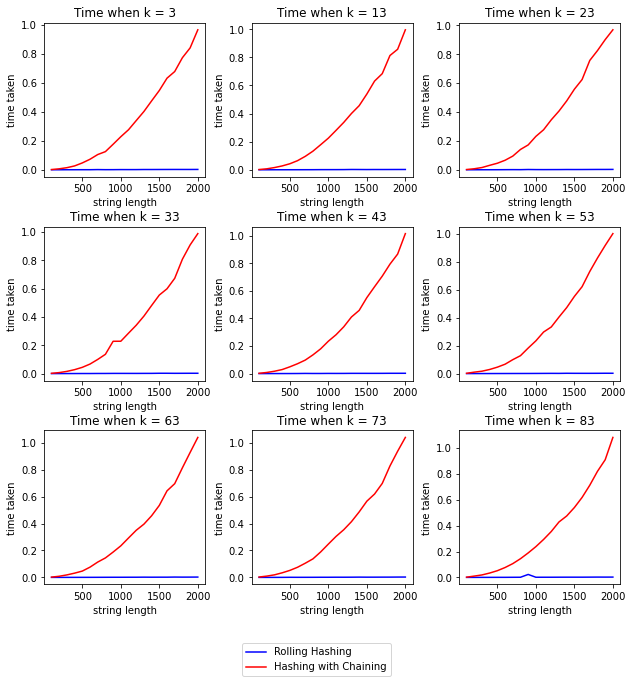

In [16]:
def get_random_string(k):
    """
    Creates random string of a specific length
    Input:
    - k: int 
         length of string
    Output:
    - result: str
         random string of length k
    """
    result = ''.join(random.choice(string.ascii_lowercase) for i in range(k))
    return result

count = 0

fig, axs = plt.subplots(3, 3, figsize=(10,10)) # create subplots matrix 3x3

axs = axs.ravel()

for k in range(3, 84, 10): # loop through every tenth k value 
    dict_rh = {}
    dict_regular = {} 
    for i in range(100, 2100, 100):
        # get 2 random strings
        string_x = get_random_string(i)
        string_y = get_random_string(i)
        
        l = []
        
        # perform 3 iterations of time measurements for rolling hashing
        for j in range(1,3):
            start = time.time()
            rh_get_match(string_x, string_y, k)
            end = time.time()
            l.append(end-start)
        dict_rh[i] = sum(l)/ len(l)

        l = []
        
        # perform 3 iterations of time measurements for regular hashing
        for j in range(1,3):
            start = time.time()
            regular_get_match(string_x, string_y, k)
            end = time.time()
            l.append(end-start)
        dict_regular[i] = sum(l)/ len(l)
        
    axs[count].plot(list(dict_rh.keys()), list(dict_rh.values()), color = 'blue', label = 'Rolling Hashing')
    axs[count].plot(list(dict_regular.keys()), list(dict_regular.values()), color = 'red', label = 'Hashing with Chaining')
    axs[count].set_xlabel('string length')
    axs[count].set_ylabel('time taken')
    axs[count].set_title('Time when k = ' + str(k))
    count += 1
    
fig.tight_layout()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
fig.legend(lines, ['Rolling Hashing', 'Hashing with Chaining'], loc = 'lower center', borderaxespad=0.1)
plt.show()


It clearly seems that the rolling hashing is much more efficient than regular hashing. It is expected because it is much more optimized to deal with strings.

Now, we will dive deep into why the rolling hashing in Rabin Karp Algorithm has the linear average case time complexity of $O(m+n)$, while the regular hashing has $O(n*m)$ time complexity.

We will start with Rabin Karp Algorithm in plagiarism detector. 

1. Putting all substrings of the first string into the hash table using rolling hashing takes $O(m)$ time, where m is the size of the string.

2. Calculating hash values for all the substrings in the second string takes $O(n)$ time, where n is the size of the string.

3. The comparison in the case the hashes are the same takes $O(k)$ time, because we need to compare k characters in two substrings.

4. The overall time complexity therefore is $O(m) + O(n)*O(k)$ or $O(m+n)$ as k can be ignored as it is smaller than n.

This is the average case; however, the worst case of the algorithm is $O(n*m)$  and it can be the case if we have a bad hash function which results in false positives at every iteration. For example, if we have mod by 1. We will need to check every word in the list of hash value 0. It will lead to $O(n*m)$ time complexity.

As we can see from the graphs, Rabin Karp Algorithm has a linear time complexity and it is great choice for this problem.

Next, we will look at the regular hashing solution. 

1. Obtaining all the substrings of first and second strings in lists takes $O(n)$ and $O(m)$ accordingly.

2. Calculating hash values for all the substrings in the first string and put them into the hash table takes $O(n)$.

3. Calculating hash values for all the substrings in the second string takes $O(n)$. Then, we also check if the hash is in the hash table: if so, we check every string in the sublist for this hash and find the same ones. This step can take from $O(k)$ to $O(k*m)$ depending on the number of collisions.

4. The overall time complexity therefore is $O(n)*O(n) + O(m)+O(m) + O(n)*O(k) $ or $O(mn)$ at least as k can be ignored as it is smaller than n. We have $O(n)*O(n) + O(m)+O(m)$ terms as we need firstly to extract all substrings and then calculate the hash for all of them separately unlike how we did it in rolling hashing.

The time complexity for the regular hashing is about quadratic, which makes it much less useful for this context. Even when there are no collisions, this algorithm performs badly.

## Practical Implementation: Plagiarism Percentage Counter

Right now the two algorithms are not giving us much in terms of understanding the level of plagiarism in each case. For the small text, 100 similar 3-grams are a lot, so the percent of plagiarism is huge, while for the large text it can even mean that there is no plagiarism at all (i.e., if all of these similarities are in the word 'the'). Therefore, we use metric provided in the paper of Siahaan, Rahim, Mesran, &amp; Siregar (2017), which defines the percentage of plagiarism as a division of the number of the same uniques hashes between two strings multiplied by two on the sum of the number of all unique hashes in both texts.

To calculate this metric, we used the rolling hashing as it is faster than the regular hashing.

In [11]:
def plagiarism_percentage(x, y, k):
    
    """
    Calculates the plagiarism percentage using rolling hashing.
    
    Input:
    - x : str
             preprocessed string
    - y : str
             preprocessed string
    - k : int
             size of substring      
             
    Output:
    - percentage : float
             plagiarism percentage
           
    """
    
    def hash_val_for_string_pp(string, k, hash_table, q): 
        
        """
        Put all k-gram substrings to the hash table as values (without indices), while hashes are keys.

        Input:
        - string : str
                 preprocessed string
        - k : int
                 size of substring      
        - hash_table : dict
                 empty hash table
        - q : int
                 prime number to use in hash function

        Output:
        - hash_table : dict
                 hash table with all the k-grams from the string 

        """
    
        d = 256 # size of the vocabulary
        h = 1 
        
        for i in range(k-1): # calculate h
            h = (h * d)% q  
            
        t = 0
        
        for i in range(k):
            t = (d * t + ord(string[i]))% q # calculate hash value of the first window

        hash_table[t] = [string[:k]] # put the first window in the hash table

        N = len(string) # length of the string 

        for i in range(N - k + 1): # loop to go through all substrings (N-k+1) because the last window must be
                                   # of the length k

            if i < N - k:  # if i < N - k, renew hash value
                t = (d * (t - ord(string[i]) * h) + ord(string[i + k])) % q # recalculate the hash value

                if t < 0:  # if hash value is negative -> make it positive
                    t = t + q 

                if t in hash_table: # if hash in the hash table,
                    hash_table[t].append(string[i+1: i+1+k]) # add substring to the sublist for this hash

                else: # if hash is not in the hash table,
                    hash_table[t] = [string[i+1: i+1+k]] # create sublist with the substring in it

        return hash_table

    # create two hash tables
    hash_table_x = {} 
    hash_table_y = {}
    
    # put all k-grams of 1st and 2nd strings in them
    hash_table_x = hash_val_for_string_pp(x, k, hash_table_x, 10007)
    hash_table_y = hash_val_for_string_pp(y, k, hash_table_y, 10007)
    
    # create a set of unique hash values in 1st and 2nd strings
    set_x = set(hash_table_x.keys())   
    set_y = set(hash_table_y.keys()) 
    
    l = list(set_x & set_y) # find the common hashes in the two sets
    
    li = []
    
    # check if the substrings with the same hashes are actually the same
    for i in l:
        # create sets of unique substrings with the specific hash
        set_x_ad = set(hash_table_x[i])   
        set_y_ad = set(hash_table_y[i])
        
        # if there are similar substrings, append the hash into the list
        if len(set_x_ad & set_y_ad) != 0:
            li.append(i)
            
    # find the number of similar hashes       
    length = len(li)

    return (2*length)/(len(set_x)+len(set_y)) * 100 # return the plagiarism percentage metric

It is important to mention that as Siahaan, Rahim, Mesran, & Siregar (2017) said the different size of k-grams can provide different estimates for the percentage. For example, if we use 3-grams the percentage can be very high, while if we use 100-grams the percentage can be even 0. It is because it is much easier to find the same 3-grams than 100-grams.

This observation lead to the conclusion that we must try to find appropriate k-gram size in every particular case to estimate the level of plagiarism as accurately as possible.

We will show it in the concrete example. We will try different k-grams and assess the percentage of plagiarism in the second text (as first one is the original one).

In [28]:
# The original text (string_x) us brought from Macroeconomics. (2020, December 06). Retrieved December 18, 2020, from https://en.wikipedia.org/wiki/Macroeconomics
# This example of plagiarism (string_y) is brought from Paraphrasing (or Summarizing) Without Citation - NIU - Academic Integrity Tutorial for Students. (n.d.). Retrieved December 18, 2020, from https://www.niu.edu/academic-integrity/students/plagiarism/paraphrasing-without-citation.shtml

string_x = preprocessing("The original theoretical impetus was the charge that Keynesian economics lacks microeconomic foundations -- i.e. its assertions are not founded in basic economic theory. This school emerged during the 1970s. This school asserts that it does not make sense to claim that the economy at any time might be 'out-of-equilibrium'. Fluctuations in aggregate variables follow from the individuals in the society continuously re-optimizing as new information on the state of the world is revealed.")
string_y = preprocessing("Scholars in the school of new classical economics, which emerged in the 1970s, focus on the belief that the school of Keynesian economics is misguided. New classical scholars assert that the economy is never unbalanced, as Keynesian scholars believe, but instead that changes in an economy result from people's changing their spending habits as they interpret the news about the world.")

print('plagiarism percentage for k = 3:', plagiarism_percentage(string_x, string_y, 3))
print('plagiarism percentage for k = 5:', plagiarism_percentage(string_x, string_y, 5))
print('plagiarism percentage for k = 7:', plagiarism_percentage(string_x, string_y, 7))
print('plagiarism percentage for k = 10:', plagiarism_percentage(string_x, string_y, 10))
print('plagiarism percentage for k = 20:', plagiarism_percentage(string_x, string_y, 20))

plagiarism percentage for k = 3: 34.074074074074076
plagiarism percentage for k = 5: 14.580031695721077
plagiarism percentage for k = 7: 8.132530120481928
plagiarism percentage for k = 10: 4.123711340206185
plagiarism percentage for k = 20: 0.0


As we can see, for the small size of k-gram, the percentage of plagiarism is big (~34%), while for 20-gram it is 0. We should use k between 5-10, which is the usual size of one word, so we can perform the most accurate analysis of plagiarism.

## Conclusion

We built and analysed two approaches to string matching: Rolling Hashing and Regular Hashing. We found that Rolling Hashing is much more appropriate and optimized algorithm in terms of time complexity. It can scale easily to a huge texts and even books, while regular hashing is a time-consuming solution (and even impossible for large inputs).

We also constructed the practical implementation of rolling hashing to calculate the plagiarism percentage between two texts.

## LOs

**\#DataStructures:** Here, I used Hash Table to store the hash values of specific substrings and search for the substrings in $O(1)$ time. Hash table is the best choice of data structure for this particular task because it can be used to search and add elements in $O(1)$ time. To implement the hash table, I used python implementation of hash table - dictionary. It is a very optimized version of hash table. I also used chaining as a way to handle collisions. I chose this method because the number of collisions is small and this method is reliable (there will never be the case in which the element cannot be added as it can be in double hashing or with probing). 

**\#PythonProgramming:** In this paper, I used python extensively to produce all the algorithms implementations as well as to assess the efficiency of these implementations. I used a lot of functions in this assignment.

**\#ComplexityAnalysis:** In this paper, I did a tough complexity analysis of compound functions. I performed additions and multiplication of complexities to obtain the results. I also described which algorithm is better in terms of time complexity.

**\#CodeReadability:** I used comment everywhere in the code. Also, I included docstrings in every function with the description of the input and output of the function. I tried to make the code clear and comprehensive by breaking it down into small and nice functions.

**\#ComputationalSolutions:** Here, I identified the solution to the plagiarism detection problem by using small and easy to understand functions. I also searched for the more practical implementation of rolling hashing and performed it in python. As of now, this assignment has not only the theoretical functions, which are not yet translated to the real applications, but also the practical function, which can actually calculate the percentage of plagiarism using rolling hashing.

## HCs

**\#optimization:** Here, my objective function was to minimize running time of the string matching algorithm. The constraint is that we need to find all the same substrings with their indices. To perform an optimization, I optimized the process of calculating hash values with rolling hashing. It helped me to decrease the running time from the quadratic to linear.

**\#breakitdown:** To create such a difficult algorithm as string matching, I needed to break the problem down into feasible steps: put hashes of all substrings in first string into hash table, perform similarity check, and then return the list of matches. To make it easier for me and other people who will work with my code, I broke this huge task into small subfunctions, which made it easier for me to solve the problem correctly (as I could check how each subfunction works rather than debugging the big unfeasible function).

**\#critique:** To assess both algorithms and find the best option, I needed to critique both of them. I used appropriate justification (graphs) to talk about their running times and evaluate which one is more optimized. For this assessment, I needed to extensively work with the code, try different inputs, look at how the program performs. This analysis led to the more elaborated critique of both methods in section 'Use in the Plagiarism Context'.

## References:

1. Plagiarism. (n.d.). Retrieved December 18, 2020, from https://www.ox.ac.uk/students/academic/guidance/skills/plagiarism

2. Examples of Plagiarism. (n.d.). Retrieved December 18, 2020, from https://www.bowdoin.edu/dean-of-students/judicial-board/academic-honesty-and-plagiarism/examples.html

3. Academic Integrity at MIT. (n.d.). Retrieved December 18, 2020, from https://integrity.mit.edu/handbook/academic-writing/avoiding-plagiarism-paraphrasing

4. Thurow, L. (1993). Fortune Favors the Bold (p. 6). New York: Harper Collins

5. Paraphrasing (or Summarizing) Without Citation - NIU - Academic Integrity Tutorial for Students. (n.d.). Retrieved December 18, 2020, from https://www.niu.edu/academic-integrity/students/plagiarism/paraphrasing-without-citation.shtml

6. Macroeconomics. (2020, December 06). Retrieved December 18, 2020, from https://en.wikipedia.org/wiki/Macroeconomics

7. Siahaan, A. P., Rahim, R., Mesran, M., &amp; Siregar, D. (2017). K-Gram As A Determinant Of Plagiarism Level in Rabin-Karp Algorithm. doi:10.31227/osf.io/trfkh